# Find Threshold

Using canonical AP1 motifs and OS, S and K from BPNet. Find appropriate log-odds threshold by scoring modisco hits.

In [114]:
import modisco
import h5py
import deepdish
import intervaltree
from collections import defaultdict, OrderedDict, Counter
from modisco.visualization import viz_sequence
import matplotlib

# for pdf text saving 
matplotlib.rcParams['pdf.fonttype'] = 42

from matplotlib import pyplot as plt
import numpy as np
import tqdm
import modisco
from modisco.visualization import viz_sequence
import tqdm
import pyBigWig
import pyfaidx
from math import ceil

In [2]:
import keras
from keras.utils import CustomObjectScope

import sys
sys.path.append("/users/surag/kundajelab/chrombpnet-lite/src/")
from utils.loss import multinomial_nll
from utils import one_hot
from pathlib import Path
import pandas as pd

Using TensorFlow backend.
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/s

In [3]:
!pip freeze | grep modisco

modisco==0.5.14.0


In [4]:
import os

In [5]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [6]:
def revcomp(x):
    # Assuming ACGT
    return x[::-1][:,::-1]

## Load Canonical Motifs

These are motifs from external sources (e.g. ChIP-seq/BPNet) that will be used to call instances. We need to find reasonable thresholds for them.

In [25]:
KLF_canonical = np.loadtxt("./motif_scans/motifs/Klf4.txt")
SOX_canonical = np.loadtxt("./motif_scans/motifs/Sox2.txt")
OS_canonical = np.loadtxt("./motif_scans/motifs/Oct4-Sox2.txt")
AP1_canonical = np.loadtxt("./motif_scans/motifs/AP1.txt")

## Load Motif Data

In [8]:
# will crop to this region around center (summit of peak) [this is what was done for this data when modisco was called]
MODISCO_CROP_WIDTH = 500

In [9]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [10]:
def get_regions(regions_file, crop_width):
    with open(regions_file) as f:
        scored_regions = [x.strip().split('\t') for x in f]

    # importance scores are computed centered at summit (2nd col + 10th col)
    scored_regions = [(x[0], int(x[9])+int(x[1])-crop_width//2, int(x[9])+int(x[1])+crop_width//2) for x in scored_regions]
    
    return scored_regions

In [30]:
def fetch_data(modisco_hdf5, pattern_name, pattern_start, pattern_end,
               imp_scores, regions, modisco_crop_width, genome, 
               rc_everything=False, expand_bw=100):
    """
    this function basically goes through the seqlets of a given pattern (pattern_name)
    it pulls out raw shap scores for each seqlet, its coordinates, whether it's RC-ed,
    its subcluster indices
    also pulls out raw insertions for each seqlet (out expand_bw on both sides), and same
    for predicted profiles w/ and w/o bias 
    
    returned seqlets all have the same orientation!
    pattern_start -> start of pattern within seqlet ([0,seqlen_len)]
    pattern_end-> start of pattern within seqlen ((pattern_start,seqlen_len)]
    """
    
    assert(len(regions)==imp_scores['shap']['seq'].shape[0])
    
    # region sliced out and used for modisco
    imp_width = imp_scores['shap']['seq'].shape[-1]
    imp_crop_start = imp_width//2 - modisco_crop_width//2
    imp_crop_end = imp_width//2 + modisco_crop_width//2
    
    pattern = modisco_hdf5['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns'][pattern_name]
    
    seqlet_len = pattern["sequence"]["fwd"].shape[0]
    
    subcluster_idxs = np.array(list(pattern["subclusters"]))
    
    seqlet_coords = []
    seqlet_is_rc = []
    seqlet_shaps = []
    seqlet_one_hots = []
    
    # fetch info from the bigwigs where the seqlets are present
    for i in tqdm.trange(len(pattern['seqlets_and_alnmts']['seqlets'])):
        x = pattern['seqlets_and_alnmts']['seqlets'][i]
        
        # index into regions/imp_scores, i.e. which entry in regions does each seqlet come from
        idx = int(x.decode('utf8').split(',')[0].split(':')[1])
        start = int(x.decode('utf8').split(',')[1].split(':')[1])
        rc = eval(x.decode('utf8').split(',')[3].split(':')[1])

        reg = regions[idx]

        cur_proj_shap_scores = imp_scores['projected_shap']['seq'][idx][:, imp_crop_start:imp_crop_end].transpose()
        cur_one_hot = imp_scores['raw']['seq'][idx][:, imp_crop_start:imp_crop_end].transpose()

        seqlet_is_rc.append(rc)
        
        if rc:
            seqlet_shaps.append(revcomp(cur_proj_shap_scores[start+(seqlet_len-pattern_end):start+(seqlet_len-pattern_start)]))
            seqlet_one_hots.append(revcomp(cur_one_hot[start+(seqlet_len-pattern_end):start+(seqlet_len-pattern_start)]))

            start_coord = reg[1]+start+(seqlet_len-pattern_end)
            end_coord = reg[1]+start+(seqlet_len-pattern_start)
            seqlet_coords.append([reg[0], start_coord, end_coord])
        
        else:
            seqlet_shaps.append(cur_proj_shap_scores[start+pattern_start:start+pattern_end])
            seqlet_one_hots.append(cur_one_hot[start+pattern_start:start+pattern_end])
            
            start_coord = reg[1]+start+pattern_start
            end_coord = reg[1]+start+pattern_end
            seqlet_coords.append([reg[0], start_coord, end_coord])
            
    # RC-ing all instances
    seqlet_shaps = np.array(seqlet_shaps) #[:,::-1,::-1]
    seqlet_one_hots = np.array(seqlet_one_hots)  # [:,::-1,::-1]
    
    if rc_everything:
        seqlet_shaps = seqlet_shaps[:, ::-1, ::-1]
        seqlet_one_hots = seqlet_one_hots[:, ::-1, ::-1]
        seqlet_pred_wo_bias = seqlet_pred_wo_bias[:, ::-1]
        seqlet_pred_w_bias = seqlet_pred_w_bias[:, ::-1]
        seqlet_insertions = seqlet_insertions[:, ::-1]
    
    return seqlet_coords, seqlet_is_rc, subcluster_idxs, seqlet_shaps, seqlet_one_hots

### High OSK MoDISco [OCT-SOX, KLF and SOX motifs]

In [13]:
HIGH_OSK_MODISCO_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/modisco/modisco_results_allChroms_counts.hdf5"
HIGH_OSK_HDF5_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/interpret/counts_scores.h5"
HIGH_OSK_REG_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/interpret/interpreted_regions.bed"

In [14]:
high_OSK_modisco = h5py.File(HIGH_OSK_MODISCO_PATH, 'r')

In [15]:
high_OSK_imp_scores = deepdish.io.load(HIGH_OSK_HDF5_PATH)

In [16]:
high_OSK_regions = get_regions(HIGH_OSK_REG_PATH, MODISCO_CROP_WIDTH)

In [15]:
# patterns

# These coordinates are slightly different from those in other notebook since they will match the size of the BPNet motifs (OS, S, K)

# OS: pattern_0 : 8 - 24
# KLF: pattern_1 : 6 - 16

In [31]:
KLF_coords, KLF_is_rc, \
KLF_subcluster_idxs, \
KLF_shaps, KLF_one_hots = \
        fetch_data(high_OSK_modisco, "pattern_1", 6, 16,
                   high_OSK_imp_scores, high_OSK_regions, 
                   MODISCO_CROP_WIDTH, hg38, rc_everything=False, expand_bw=100)

100%|██████████| 6288/6288 [00:01<00:00, 3385.06it/s]


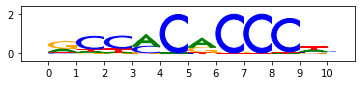

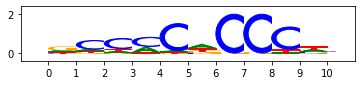

In [32]:
viz_sequence.plot_weights(viz_sequence.ic_scale(KLF_canonical, background=[0.25]*4), figsize=(6,1))
viz_sequence.plot_weights(viz_sequence.ic_scale(KLF_one_hots.mean(0), background=[0.25]*4), figsize=(6,1))

In [39]:
OS_coords, OS_is_rc, \
OS_subcluster_idxs, \
OS_shaps, OS_one_hots = \
        fetch_data(high_OSK_modisco, "pattern_0", 7, 23,
                   high_OSK_imp_scores, high_OSK_regions, 
                   MODISCO_CROP_WIDTH, hg38, rc_everything=False, expand_bw=100)

100%|██████████| 9502/9502 [00:02<00:00, 3317.94it/s]


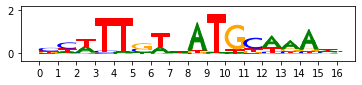

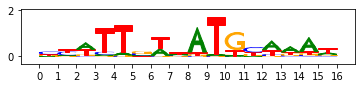

In [40]:
viz_sequence.plot_weights(viz_sequence.ic_scale(OS_canonical, background=[0.25]*4), figsize=(6,1))
viz_sequence.plot_weights(viz_sequence.ic_scale(OS_one_hots.mean(0), background=[0.25]*4), figsize=(6,1))

In [45]:
SOX_coords, SOX_is_rc, \
SOX_subcluster_idxs, \
SOX_shaps, SOX_one_hots = \
        fetch_data(high_OSK_modisco, "pattern_4", 0, 16,
                   high_OSK_imp_scores, high_OSK_regions, 
                   MODISCO_CROP_WIDTH, hg38, rc_everything=False, expand_bw=100)

100%|██████████| 585/585 [00:00<00:00, 2656.68it/s]


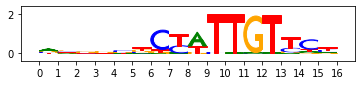

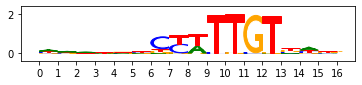

In [46]:
viz_sequence.plot_weights(viz_sequence.ic_scale(SOX_canonical, background=[0.25]*4), figsize=(6,1))
viz_sequence.plot_weights(viz_sequence.ic_scale(SOX_one_hots.mean(0), background=[0.25]*4), figsize=(6,1))

## Computing log-odds scores

In [53]:
KLF_canonical_logodds_mat = np.log((KLF_canonical+1e-10)/0.25)
OS_canonical_logodds_mat = np.log((OS_canonical+1e-10)/0.25)
SOX_canonical_logodds_mat = np.log((SOX_canonical+1e-10)/0.25)

In [54]:
KLF_log_odd_scores = np.sum(KLF_one_hots*KLF_canonical_logodds_mat, axis=(1,2))
OS_log_odd_scores = np.sum(OS_one_hots*OS_canonical_logodds_mat, axis=(1,2))
SOX_log_odd_scores = np.sum(SOX_one_hots*SOX_canonical_logodds_mat, axis=(1,2))

In [63]:
np.quantile(KLF_log_odd_scores, .1), np.quantile(OS_log_odd_scores, .1), np.quantile(SOX_log_odd_scores, .1)

(2.437392685854692, 4.230618897170591, 3.4201309602242116)

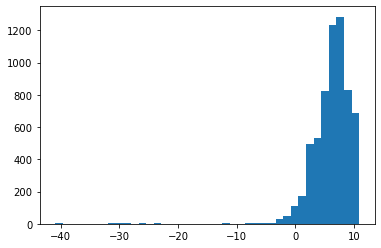

In [64]:
plt.hist(KLF_log_odd_scores, bins=40)
plt.show()

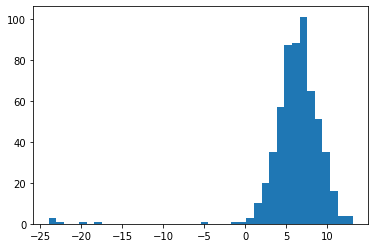

In [65]:
plt.hist(SOX_log_odd_scores, bins=40)
plt.show()

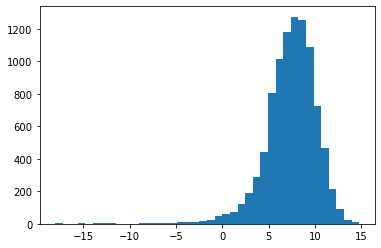

In [110]:
plt.hist(OS_log_odd_scores, bins=40)
plt.show()

In [105]:
pwm_dict = {"KLF": {"pwm": KLF_canonical, "scores": KLF_log_odd_scores},
            "OCTSOX": {"pwm": OS_canonical, "scores": OS_log_odd_scores},
            "SOX": {"pwm": SOX_canonical, "scores": SOX_log_odd_scores}}

for x in pwm_dict:
    with open("./motif_scans/motifs/{}.adjusted.motif".format(x), 'w') as f:
        f.write(">{}\t{}\t{}\t-\t-\t-\n".format(x,x,np.quantile(pwm_dict[x]["scores"], 0.1)))
        for y in pwm_dict[x]["pwm"]:
            f.write("\t".join([str(v) for v in y]) + "\n")

## AP1

In [66]:
FIBR_MODISCO_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/modisco/modisco_results_allChroms_counts.hdf5"
FIBR_HDF5_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/interpret/counts_scores.h5"
FIBR_REG_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/interpret/interpreted_regions.bed"

In [67]:
fibr_modisco = h5py.File(FIBR_MODISCO_PATH, 'r')

In [ ]:
fibr_imp_scores = deepdish.io.load(FIBR_HDF5_PATH)

In [ ]:
fibr_regions = get_regions(FIBR_REG_PATH, MODISCO_CROP_WIDTH)

In [90]:
AP1_coords, AP1_is_rc, \
AP1_subcluster_idxs, \
AP1_shaps, AP1_one_hots = \
        fetch_data(fibr_modisco, "pattern_1", 6, 16,
                   fibr_imp_scores, fibr_regions, 
                   MODISCO_CROP_WIDTH, hg38, rc_everything=False, expand_bw=100)

100%|██████████| 5056/5056 [00:01<00:00, 3322.26it/s]


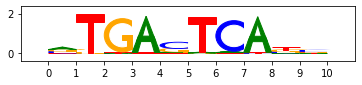

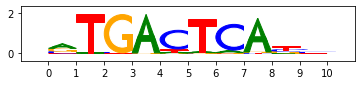

In [91]:
viz_sequence.plot_weights(viz_sequence.ic_scale(AP1_canonical, background=[0.25]*4), figsize=(6,1))
viz_sequence.plot_weights(viz_sequence.ic_scale(AP1_one_hots.mean(0), background=[0.25]*4), figsize=(6,1))

In [92]:
AP1_logodds_mat = np.log((AP1_canonical+1e-10)/0.25)

In [93]:
AP1_log_odd_scores = np.sum(AP1_one_hots*AP1_logodds_mat, axis=(1,2))

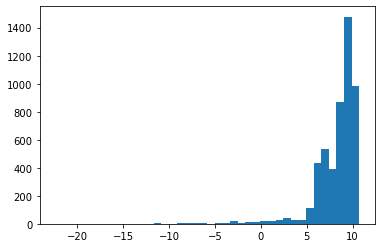

In [94]:
plt.hist(AP1_log_odd_scores, bins=40)
plt.show()

In [95]:
np.quantile(AP1_log_odd_scores, .1)

6.121883562003923

In [106]:
pwm_dict = {"AP1": {"pwm": AP1_canonical, "scores": AP1_log_odd_scores}}

for x in pwm_dict:
    with open("./motif_scans/motifs/{}.adjusted.motif".format(x), 'w') as f:
        f.write(">{}\t{}\t{}\t-\t-\t-\n".format(x,x,np.quantile(pwm_dict[x]["scores"], 0.1)))
        for y in pwm_dict[x]["pwm"]:
            f.write("\t".join([str(v) for v in y]) + "\n")

---